# **Database Monitoring Script - Cocaine Seizures 2025 (Google Sheets)**
#### InSight Crime - MAD Unit 
June, 2025

---------------------



## Setup

#### Version Control

The project is created within a single GitHub repository ([FelipeVillota/db-check-cocaine-seizures](https://github.com/FelipeVillota/db-check-cocaine-seizures)). I keep the repository `private` with the possibility to give access to the online repo at any time. 

#### Reproducible Environment

In [ ]:
# IMPORTANT
# To create venv
# python -m venv venv-db-watch

# To activate environment, run in Terminal:
# # (optional, temporary auth) 
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass 
# venv-db-watch\Scripts\activate

# Then select respective kernel --> also install ipykernel package to connect to kernel

# Update list master list
# pip freeze > requirements.txt

In [ ]:
# Checking venv-db-watch works
import sys
print(sys.executable)

#### Loading Libraries

In [ ]:
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas

In [2]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# pip freeze > requirements.txt

### Accessing the API

This creates a modular client (frontend) call that is able to extract the desired subset of data from the API server (backend); -and, make it easily reusable for future queries.


In [8]:
# Configure Google Drive API

# Path to your service account key file
SERVICE_ACCOUNT_FILE = 'C:/Users/USER/Desktop/ic/llavero/summer-sector-439022-v6-2eafffbbfb90.json' # Update with the actual path or team credentials file

# Original (latest version) Google Sheet ID
ORIGINAL_SPREADSHEET_ID =  '1t61MafCmnRe2QN082Bk1V0IxBSIW8UUqH1g5mULgb2o' 

# Test Google Sheet ID
TEST_SPREADSHEET_ID = '1tERxVx_Ay4WDOXIvEXezFpiBZKBPUJNuZQl8NUpHt1g' 
 
# Define the sheet tab or range to read
RANGE_NAME = '2025'

# Define scopes for Google Sheets and Drive API
SCOPES = ['https://www.googleapis.com/auth/spreadsheets', 
          'https://www.googleapis.com/auth/drive']

In [9]:
# Authenticate and build both Sheets and Drive services
creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)
sheet_service = build('sheets', 'v4', credentials=creds)
drive_service = build('drive', 'v3', credentials=creds)

In [10]:
# Verify last modifying user and time of the original spreadsheet. This information is related to the file itself, not to specific content (sheets, cells, rows)

from googleapiclient.discovery import build
from datetime import datetime
import pytz

def get_last_modifying_user(drive_service, file_id):
    try:
        # Get revisions (only the last one)
        revisions = drive_service.revisions().list(
            fileId=file_id,
            fields="revisions(modifiedTime,lastModifyingUser)"
        ).execute().get('revisions', [])
        
        if not revisions:
            return "No revisions found."
        
        last_revision = revisions[-1]  # Most recent revision
        user_info = last_revision.get('lastModifyingUser', {})
        display_name = user_info.get('displayName', 'Unknown')
        email = user_info.get('emailAddress', 'Unknown')
        modified_time = last_revision.get('modifiedTime', 'Unknown')
        
        # Convert to readable datetime
        if modified_time != 'Unknown':
            dt = datetime.strptime(modified_time, "%Y-%m-%dT%H:%M:%S.%fZ")
            dt = dt.replace(tzinfo=pytz.UTC)
            modified_time = dt.strftime("%Y-%m-%d %H:%M:%S (UTC)")
        
        return {
            "user_display_name": display_name,
            "user_email": email,
            "modified_time": modified_time
        }
    
    except Exception as e:
        return f"Error: {str(e)}"

# Usage
last_modifier = get_last_modifying_user(drive_service, TEST_SPREADSHEET_ID)
print(f"🔄 Last modified by: {last_modifier['user_display_name']} ({last_modifier['user_email']})")
print(f"⏰ Last modified at: {last_modifier['modified_time']}")

TypeError: string indices must be integers, not 'str'

### Loading Data

In [11]:
# Load data
 
# Call the Sheets API to read data
sheet = sheet_service.spreadsheets()
result = sheet.values().get(spreadsheetId=TEST_SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(values[1:], columns=values[0])
print(df.head()) 

      Type   Time unit        Date Date 2  Year Month Day Duration  \
0  Seizure  Individual  2025-03-24         2025     3  24            
1  Seizure  Individual  2025-03-23         2025     3  23            
2  Seizure  Individual  2025-03-22         2025     3  22            
3  Seizure  Individual  2025-03-22         2025     3  22            
4  Seizure  Individual  2025-03-19         2025     3  19            

                       Type Drugs Quantity  ... Destition - department.state  \
0                         Cocaine       10  ...                                
1                         Cocaine      2.5  ...                                
2                         Cocaine     2619  ...                                
3  Other (explain in Description)     1240  ...                                
4                         Cocaine    16.05  ...                                

  Destition - Municipality/Port Destition 2 - Country  \
0                                        

### Pre-processing

In [12]:
# Handle Missing/Invalid Values
 
df = df.replace('', pd.NA)  # Convert empty strings to NA
df = df.replace(r'^\s*$', pd.NA, regex=True)  # Convert whitespace to NA
print("✓ Converted empty strings/whitespace to NA values")

✓ Converted empty strings/whitespace to NA values


In [13]:
# Indentify Existing Dropdowns
 
def get_sheet_dropdowns(spreadsheet_id, sheet_name, creds):
    service = build('sheets', 'v4', credentials=creds)
    sheet_metadata = service.spreadsheets().get(
        spreadsheetId=spreadsheet_id,
        ranges=[sheet_name],
        includeGridData=True
    ).execute()

    dropdowns_by_column = {}

    for sheet in sheet_metadata['sheets']:
        if sheet['properties']['title'] != sheet_name:
            continue

        col_dropdowns = {}
        rows = sheet['data'][0]['rowData']
        header_row = rows[0]['values']
        col_names = [cell.get('formattedValue', f"Column_{i}") for i, cell in enumerate(header_row)]

        for col_idx, col_name in enumerate(col_names):
            dropdowns_in_col = set()
            for row in rows[1:]:  # Skip header
                cell = row['values'][col_idx]
                if 'dataValidation' in cell:
                    dv = cell['dataValidation']
                    if dv['condition']['type'] == 'ONE_OF_LIST':
                        values = [v['userEnteredValue'] for v in dv['condition']['values']]
                        dropdowns_in_col.update(values)
            if dropdowns_in_col:
                col_dropdowns[col_name] = list(dropdowns_in_col)

        dropdowns_by_column.update(col_dropdowns)

    return dropdowns_by_column

dropdown_options = get_sheet_dropdowns(TEST_SPREADSHEET_ID, '2025', creds)

# Print results
for col, options in dropdown_options.items():
    print(f"🔽 {col}: {options}")


🔽 Type: ['Other (explain in Description)', 'Crop Eradication', 'Seizure', 'Total Crop Cultivation Estimate', 'Total Production Estimate', 'Price']
🔽 Time unit: ['Other (explain in Description)', 'Month', 'Multi-Month', 'Year', 'Multi-Year', 'Individual']
🔽 Type Drugs: ['Other (explain in Description)', 'Coca Crops', 'Cocaine Base', 'All/Unspecified/Multiple', 'Cocaine - Crack', 'Cocaine']
🔽 Weight unit: ['Other (explain in Description)', 'Plant', 'Pounds (£)', 'Euro', 'Hectare', 'Kilogram', 'USD', 'Pounds (lbs)', 'Other currency (say which in Description)', 'Percent', 'Package']
🔽 Modus Operandi/place of seizure: ['Container', 'Maritime vessel', 'Land', 'Air', 'River vessel']
🔽 Region: ['Oceania', 'Global', 'Asia', 'Caribbean', 'South America', 'Central America', 'Europe', 'North America', 'Africa']
🔽 Origin country: ['Bolivia', 'Colombia', '""', 'Peru']
🔽 Transit 1/Region: ['Oceania', 'Global', 'Asia', 'Caribbean', 'South America', 'Central America', 'Europe', 'North America', 'Africa

## Monitoring

##### Summary Stats

In [22]:
def get_dataframe_summary(df):
    # --- General DataFrame Info ---
    general_info = {
        "Shape": f"{df.shape[0]} rows × {df.shape[1]} cols",
        "Memory Usage": f"{df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB",
        "Columns with NA": f"{df.isna().any().sum()} / {len(df.columns)}",
        "Duplicate Rows": f"{df.duplicated().sum()} ({(df.duplicated().mean() * 100):.1f}%)",
        "Numeric Columns": f"{df.select_dtypes(include='number').shape[1]}",
        "Categorical Columns": f"{df.select_dtypes(include=['object', 'category']).shape[1]}",
        "Datetime Columns": f"{df.select_dtypes(include='datetime').shape[1]}"
    }

  # --- Compute dropdown options per column ---
    dropdown_options_dict = {
        col: dropdown_options.get(col, [])
        for col in df.columns
    }
    # --- Column-Level Stats ---
    column_stats = pd.DataFrame({
        'Variable': df.columns,
        'Dtype': df.dtypes.values,
        'Unique_Count': df.nunique().values,
        'NA_Count': df.isna().sum().values,
        'NA_Percentage': (df.isna().mean() * 100).round(1).values,
        'Duplicate_Count': df.apply(lambda col: col.duplicated(keep=False).sum()).values,
        'Duplicate_Percentage': (df.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(1).values,
        'Unique_Values': df.apply(lambda x: x.drop_duplicates().tolist()).values,
        'Dropdown_Options': [dropdown_options_dict[col] for col in df.columns],
        'Dropdown_Option_Count': [len(dropdown_options_dict[col]) for col in df.columns]
    }).sort_values('Unique_Count', ascending=False)


    # Format percentages
    column_stats['NA_Percentage'] = column_stats['NA_Percentage'].astype(str) + '%'
    column_stats['Duplicate_Percentage'] = column_stats['Duplicate_Percentage'].astype(str) + '%'

    return general_info, column_stats

# Run the summary
general_info, column_stats = get_dataframe_summary(df)

# Print General Info
print("=== GENERAL DATAFRAME INFO ===")
for key, value in general_info.items():
    print(f"{key}: {value}")

# Display Column Stats (including dropdown options)
print("\n=== COLUMN-LEVEL STATISTICS ===")
display(column_stats)


=== GENERAL DATAFRAME INFO ===
Shape: 478 rows × 41 cols
Memory Usage: 1.21 MB
Columns with NA: 36 / 41
Duplicate Rows: 0 (0.0%)
Numeric Columns: 0
Categorical Columns: 41
Datetime Columns: 0

=== COLUMN-LEVEL STATISTICS ===


,Variable,Dtype,Unique_Count,NA_Count,NA_Percentage,Duplicate_Count,Duplicate_Percentage,Unique_Values,Dropdown_Options,Dropdown_Option_Count
35,Description,object,473,2,0.4%,8,1.7%,"[Spanish citizen, coming from Lisbon , was sto...",[],0
39,Source link,object,459,0,0.0%,35,7.3%,[https://www.lanazione.it/firenze/cronaca/coca...,[],0
9,Quantity,object,317,3,0.6%,236,49.4%,"[10, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 55...",[],0
17,Municipality/Port,object,291,120,25.1%,232,48.5%,"[Florence, Santo Domingo, Lake Maracaibo , Eag...",[],0
11,seizure_kgs,object,253,125,26.2%,282,59.0%,"[9, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 250...",[],0
16,Department/State,object,233,44,9.2%,324,67.8%,"[<NA>, Zulia, Texas, Cáceres, Azores, Québec, ...",[],0
2,Date,object,106,2,0.4%,461,96.4%,"[2025-03-24, 2025-03-23, 2025-03-22, 2025-03-1...",[],0
24,Transit 1/Municipality,object,86,372,77.8%,408,85.4%,"[<NA>, Matapalo, Rio de Janeiro, Acapulco, Kin...",[],0
23,Transit 1/Department,object,67,360,75.3%,428,89.5%,"[Lisbon, <NA>, Santo Domingo, Paris, Puntarena...",[],0
15,Country,object,51,3,0.6%,461,96.4%,"[Italy, Dominican Republic, Venezuela, United ...",[],0


##### Missing Data Analysis


Missing values per column:
Type                                 0
Time unit                            0
Date                                 2
Date 2                             465
Year                                 2
Month                                2
Day                                  3
Duration                           464
Type Drugs                           0
Quantity                             3
Weight unit                          2
seizure_kgs                        125
Modus Operandi/place of seizure      7
Sub MO                             448
Region                               0
Country                              3
Department/State                    44
Municipality/Port                  120
Origin country                     418
Origin Area                        455
Origin municipality                463
Transit 1/Region                   298
Transit 1/country                  284
Transit 1/Department               360
Transit 1/Municipality             37

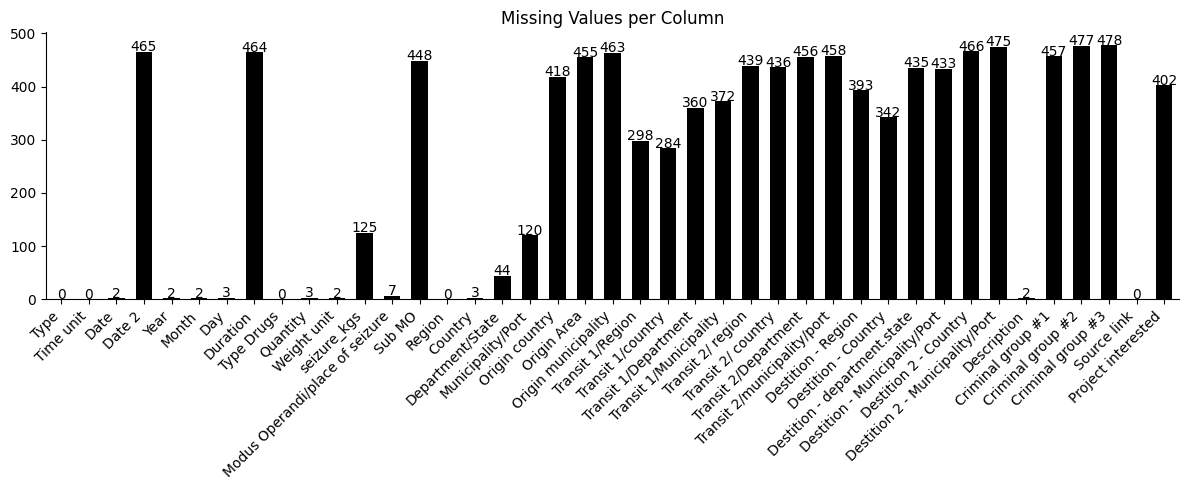

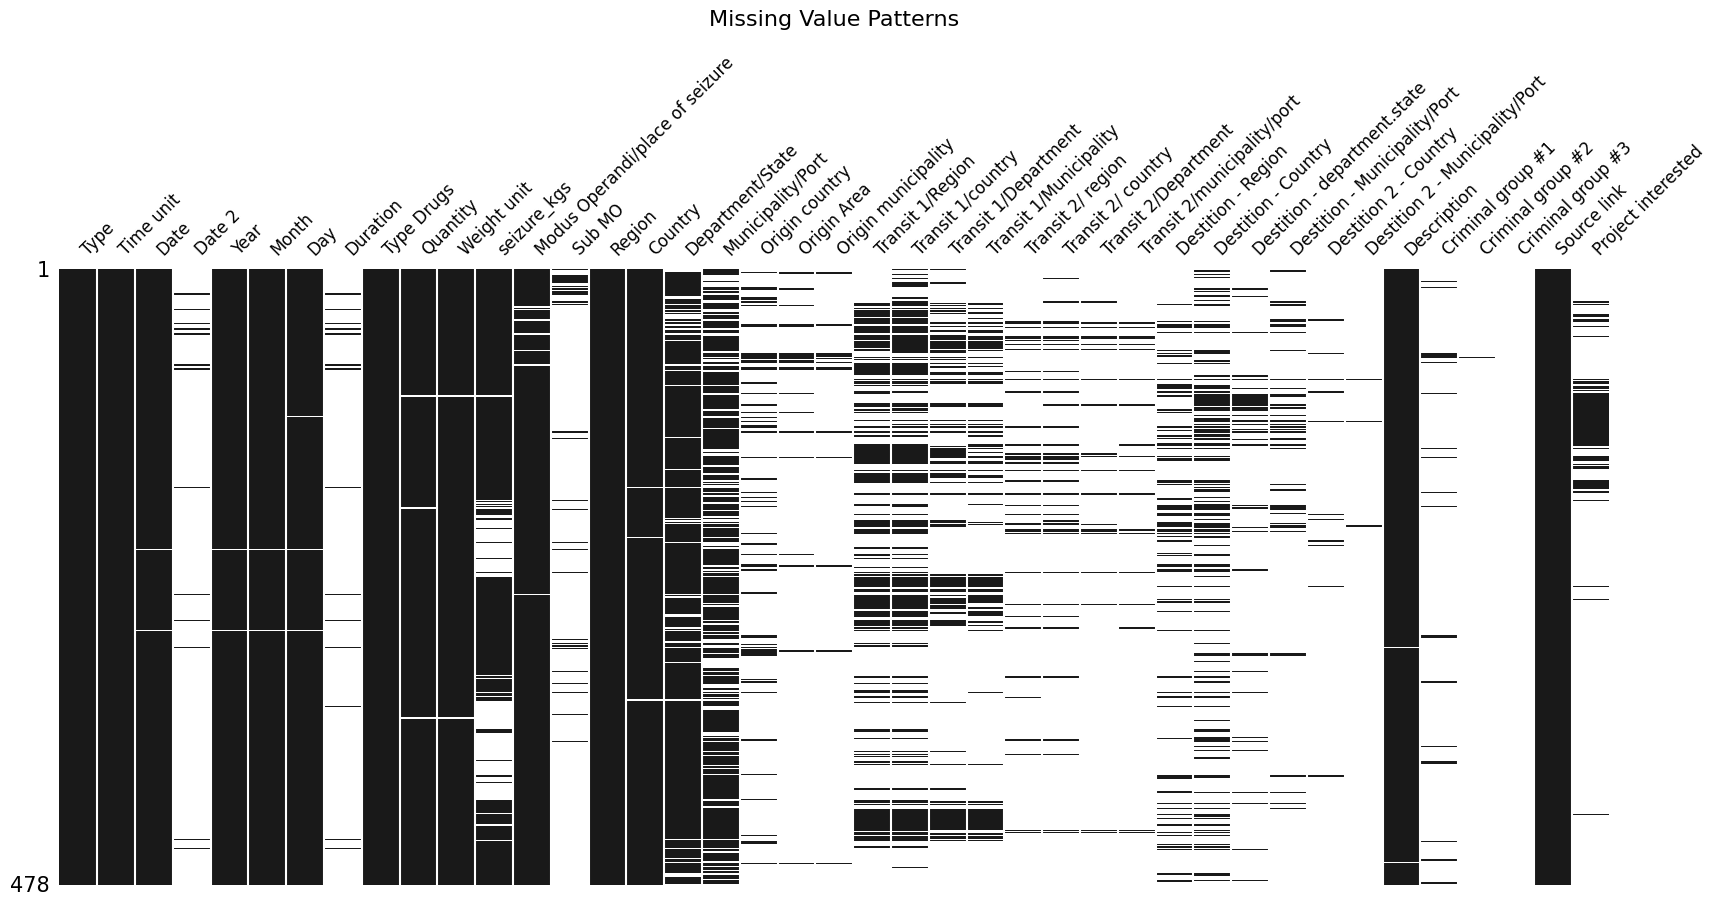

In [23]:

missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}\n")

# Visualization 1: Bar Chart
plt.figure(figsize=(12, 5))
ax = missing_values.plot(kind='bar', color="#000000", width=0.6)
ax.grid(False)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+1, 
            f'{int(i.get_height())}', 
            ha='center', fontsize=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.title("Missing Values per Column")
plt.tight_layout()
plt.show()

# Visualization 2: Missingno Matrix
msno.matrix(
    df,
    figsize=(20, 8),
    color=(0.1, 0.1, 0.1),
    sparkline=False,
    fontsize=12,
    labels=True
)
plt.title("Missing Value Patterns", fontsize=16, pad=20)
plt.show()

##### Key Variables

In [ ]:
# 1. Identify mismatches between 'Weight unit' and 'Quantity' vs 'seizure_kgs'
df['kg_unit_mismatch'] = (
    (df['Weight unit'].str.lower() == 'Kilogram') &
    (df['Quantity'] != df['seizure_kgs'])
)

# 2. Count of mismatches by weight unit
unit_mismatch_counts = df[df['kg_unit_mismatch']].groupby('Weight unit').size().reset_index(name='count')

# 3. Plot mismatches
plt.figure(figsize=(8, 5))
sns.barplot(data=unit_mismatch_counts, x='Weight unit', y='count', palette='Reds')
plt.title("Mismatches Between Quantity and Seizure_kgs by Weight Unit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Boxplot with grey boxes
sns.boxplot(data=df, x='Type Drugs', y='seizure_kgs', color='grey')

# Log scale on y-axis
plt.yscale('log')

# Red horizontal line at y=1 (which is 10^0)
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5)

plt.title("Log-Scale Seizure_kgs Distribution by Drug Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# Convert and clean seizure data
df['seizure_kgs'] = pd.to_numeric(df['seizure_kgs'], errors='coerce')

# Create pivot tables with matching structure
pivot_data = df.groupby(['Year', 'Month']).agg(
    seizure_kg=('seizure_kgs', 'sum'),
    event_count=('seizure_kgs', 'count')
).unstack(level=0)

# Extract components
seizure_kg = pivot_data['seizure_kg']
event_counts = pivot_data['event_count']

# Fill NaN values with 0 if appropriate, or use mask
seizure_kg_filled = seizure_kg.fillna(0)

# Plot combined heatmap
plt.figure(figsize=(12,6))
ax = sns.heatmap(
    seizure_kg_filled.sort_index(ascending=False),
    cmap="Greys",
    annot=event_counts.sort_index(ascending=False),
    fmt='g',
    cbar_kws={'label': 'Total Seizure (kg)'},
    linewidths=0.5,  # Adds grid lines between cells
    linecolor='lightgray'  # Color for grid lines
)

# Title and labels
plt.title("Monthly Seizures by Year\n(Event Counts shown as numbers, Quantity shown by shading)")
plt.ylabel("Month")
plt.xlabel("Year")

# Rotate year labels if needed
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_parallel_sets(df): 
    # Define the column names
    columns = ['Origin country', 'Transit 1/country', 'Transit 2/ country',
               'Destition - Country', 'Destition 2 - Country']
    
    # Copy and fill missing values
    df = df[columns].copy()
    df[columns[1]] = df[columns[1]].fillna('No Transit')
    df[columns[2]] = df[columns[2]].fillna('No Transit')
    df[columns[4]] = df[columns[4]].fillna('No Destination 2')
    
    # Filter incomplete rows
    df.dropna(subset=[columns[0], columns[3]], inplace=True)
    if df.empty:
        print("Warning: No data with both origin and destination information")
        return
    
    # Count path frequencies
    path_counts = df.groupby(columns).size().reset_index(name='count')
    
    # Prepare the plot
    plt.figure(figsize=(20, 12))

    # Map each category to a y-position (starting at 1)
    categories = {}
    for col in columns:
        values = df[col].unique()
        sorted_vals = sorted([v for v in values if "No" not in v]) + sorted([v for v in values if "No" in v])
        categories[col] = {val: idx + 1 for idx, val in enumerate(sorted_vals)}
    
    # Plot each path
    for _, row in path_counts.iterrows():
        y_values = [categories[col][row[col]] for col in columns]
        plt.plot(range(len(columns)), y_values, linewidth=row['count'] * 2, alpha=0.6)

    # X-axis: step names
    plt.xticks(range(len(columns)), ['Origin', 'Transit 1', 'Transit 2', 'Destination 1', 'Destination 2'], fontsize=12)
    
    # Y-axis: remove default numbers
    plt.yticks([])
    
    # Add node labels
    for i, col in enumerate(columns):
        for val, y in categories[col].items():
            plt.text(i, y, val, ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontsize=10)
    
    # Final touches
    plt.title("Drug Trafficking Routes: Origin → Transit 1 → Transit 2 → Destination 1 → Destination 2", 
              fontsize=16, pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage:
plot_parallel_sets(df)

In [ ]:
import numpy as np

# Group counts
mo = df['Modus Operandi/place of seizure'].value_counts().sort_index()
sub_mo = df.groupby('Modus Operandi/place of seizure')['Sub MO'].count().reindex(mo.index)

# Plot
labels = mo.index
x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(10, 8))
b1 = ax.bar(x - w/2, mo, w, label='MO Count', color="#000000")
b2 = ax.bar(x + w/2, sub_mo, w, label='Sub MO Count', color="#FA0707")

# Label bars
for bars in [b1, b2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                str(int(bar.get_height())), ha='center', va='center', color='white', fontsize=9)

# Style
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('Modus Operandi and Sub MO Counts', fontsize=14)
ax.legend()
ax.set_ylabel('Count')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()



## Validation

#### General

##### Column names

In [ ]:
# Dictionary mapping old column names to new names
custom_column_names = {
    "Type": "event_type",
    "Time unit": "time_unit",
    "Date": "date_1",
    "Date 2": "date_2",
    "Year": "year",
    "Month": "month",
    "Day": "day",
    "Duration": "duration",
    "Type Drugs": "drug_type",
    "Quantity": "quantity",
    "Weight unit": "weight_unit",
    "seizure_kgs": "seizure_kg",
    "Modus Operandi/place of seizure": "modus_operandi/place_seizure",
    "Sub MO": "sub_modus_operandi",
    "Region": "region",
    "Country": "country",
    "Department/State": "department/state",
    "Municipality/Port": "municipality/port",
    "Origin country": "origin_country",
    "Origin Area": "origin_area",
    "Origin municipality": "origin_municipality",
    "Transit 1/Region": "transit_1_region",
    "Transit 1/country": "transit_1_country",
    "Transit 1/Department": "transit_1_department/state",
    "Transit 1/Municipality": "transit_1_municipality/port",
    "Transit 2/ region": "transit_2_region",
    "Transit 2/ country": "transit_2_country",
    "Transit 2/Department": "transit_2_department/state",
    "Transit 2/municipality/port": "transit_2_municipality/port",
    "Destition - Region": "destination_1_region",
    "Destition - Country": "destination_1_country",
    "Destition - department.state": "destination_1_department/state",
    "Destition - Municipality/Port": "destination_1_municipality/port",
    "Destition 2 - Country": "destination_2_country",
    "Destition 2 - Municipality/Port": "destination_2_municipality/port",
    "Description": "description",
    "Criminal group #1": "criminal_group_1",
    "Criminal group #2": "criminal_group_2",
    "Criminal group #3": "criminal_group_3",
    "Source link": "source_link",
    "Project interested": "project_interest"
}

# Apply renaming
# df.rename(columns=custom_column_names, inplace=True)

# Now you can use df with the new column names
# print(df.columns)


##### Dropdowns

In [17]:
dropdown_options = {
    "event_type": [
        'Crop Eradication', 'Total Crop Cultivation Estimate', 'Price',
        'Total Production Estimate', 'Other (explain in Description)', 'Seizure'
    ],
    "time_unit": [
        'Multi-Year', 'Multi-Month', 'Month', 'Other (explain in Description)',
        'Individual', 'Year'
    ],
    "drug_type": [
        'Coca Crops', 'All/Unspecified/Multiple', 'Cocaine',
        'Other (explain in Description)', 'Cocaine - Crack', 'Cocaine Base'
    ],
    "weight_unit": [
        'Percent', 'Other currency (say which in Description)', 'Hectare',
        'Euro', 'Plant', 'USD', 'Other (explain in Description)',
        'Pounds (lbs)', 'Kilogram', 'Pounds (£)', 'Package'
    ],
    "modus_operandi/place_seizure": [
        'River vessel', 'Container', 'Maritime vessel', 'Land', 'Air'
    ],
    "region": [
        'Global', 'Central America', 'Asia', 'Europe', 'Oceania',
        'South America', 'Caribbean', 'North America', 'Africa'
    ],
    "origin_country": ['Peru', 'Bolivia', '""', 'Colombia'],
    
    "transit_1_region": [
        'Global', 'Central America', 'Asia', 'Europe', 'Oceania',
        'South America', 'Caribbean', 'North America', 'Africa'
    ],
    "transit_2_region": [
        'Global', 'Central America', 'Asia', 'Europe', 'Oceania',
        'South America', 'Caribbean', 'North America', 'Africa'
    ],
    "destination_1_region": [
        'Central America', 'Asia', 'Europe', 'South America',
        'Caribbean', 'North America', 'Australia', 'Africa'
    ],
    
    "project_interest": ['Cocaine Pipeline', 'El PACCTO 2.0', 'MAD', 'Dutch']
}

In [18]:
# Official list of places URL 
places_url = "https://github.com/FelipeVillota/db-check-cocaine-seizures/raw/main/other/list-of-places-ic.xlsx"

# Load the Excel file (defaulting to first sheet, or specify sheet_name if needed)
places_df = pd.read_excel(places_url)

# Preview the columns to identify the correct one for country list
print(places_df.columns)


Index(['municipality', 'department/state', 'country'], dtype='object')


In [19]:
official_countries = (
    places_df["country"]  
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    .tolist()
)

official_municipalities = (
    places_df["municipality"] 
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    .tolist()
)

official_departments_states = (
    places_df["department/state"] 
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    .tolist()
)


In [20]:
country_related_keys = [
    "origin_country",
    "transit_1_country",
    "transit_2_country",
    "destination_1_country",
    "destination_2_country"
]

for key in country_related_keys:
    dropdown_options[key] = {
        "from_data": sorted(df[key].dropna().astype(str).str.strip().unique().tolist()) if key in df.columns else [],
        "official_list": sorted(official_countries)
    }
    


In [21]:
dropdown_options["origin_country"]

{'from_data': [],
 'official_list': ['Afghanistan',
  'Albania',
  'Algeria',
  'Andorra',
  'Angola',
  'Antigua And Barbuda',
  'Argentina',
  'Armenia',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas The',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bhutan',
  'Bolivia',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cape Verde',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Colombia',
  'Comoros',
  'Congo',
  'Congo The Democratic Republic Of The',
  'Costa Rica',
  "Cote D'Ivoire (Ivory Coast)",
  'Croatia (Hrvatska)',
  'Cuba',
  'Cyprus',
  'Czech Republic',
  'Denmark',
  'Djibouti',
  'Dominica',
  'Dominican Republic',
  'East Timor',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Ethiopia',
  'Fiji Islands',
  'Finland',
  'France',
  'Gabon',
  '

#### Event Metadata

Variables: _Type, Time unit, Date, Date 2, Year, Month, Day, Duration, Description, Source link, Project interested_

In [24]:
# Date must not be empty
def validate_dates(df, date_column='Date'):
    if date_column not in df.columns:
        print(f"❌ Column '{date_column}' not found")
        return
    
    # Check for empty dates
    empty_dates = df[df[date_column].isna()]
    
    if not empty_dates.empty:
        print(f"❌ Found {len(empty_dates)} rows with empty '{date_column}' dates:")
        print(empty_dates)
    else:
        print(f"✅ All '{date_column}' dates are filled")


validate_dates(df)

❌ Found 2 rows with empty 'Date' dates:
        Type   Time unit  Date Date 2  Year Month   Day Duration Type Drugs  \
217  Seizure  Individual  <NA>   <NA>  <NA>  <NA>  <NA>     <NA>    Cocaine   
280  Seizure  Individual  <NA>   <NA>  <NA>  <NA>  <NA>     <NA>    Cocaine   

    Quantity  ... Destition - department.state Destition - Municipality/Port  \
217      120  ...                         <NA>                          <NA>   
280        3  ...                         <NA>                          <NA>   

    Destition 2 - Country Destition 2 - Municipality/Port  \
217                  <NA>                            <NA>   
280                  <NA>                            <NA>   

                                           Description Criminal group #1  \
217  En los puertos de Marín y Vigo (Pontevedra), l...              <NA>   
280  Un poco más de 3 kilos de cocaína serían envia...              <NA>   

    Criminal group #2 Criminal group #3  \
217              <NA>    

In [25]:
# Why is there Duration if there is no Date 2?  
def validate_duration(df, date_column='Date', date2_column='Date 2', duration_column='Duration'):
    if date_column not in df.columns or date2_column not in df.columns or duration_column not in df.columns:
        print(f"❌ One or more columns '{date_column}', '{date2_column}', or '{duration_column}' not found")
        return
    
    # Check for rows where Date 2 is empty but Duration is filled
    invalid_rows = df[(df[date2_column].isna()) & (df[duration_column].notna())]
    
    if not invalid_rows.empty:
        print(f"❌ Found {len(invalid_rows)} rows with '{duration_column}' filled but '{date2_column}' empty:")
        print(invalid_rows)
    else:
        print(f"✅ All '{duration_column}' values are valid with respect to '{date2_column}'")

validate_duration(df)

❌ Found 1 rows with 'Duration' filled but 'Date 2' empty:
        Type    Time unit        Date Date 2  Year Month Day   Duration  \
339  Seizure  Multi-Month  2025-06-03   <NA>  2025     6   3  10 months   

    Type Drugs Quantity  ... Destition - department.state  \
339    Cocaine      187  ...                         <NA>   

    Destition - Municipality/Port Destition 2 - Country  \
339                          <NA>                  <NA>   

    Destition 2 - Municipality/Port  \
339                            <NA>   

                                           Description Criminal group #1  \
339  El 13 de mayo de 2025, en Alsacia, Francia, la...              <NA>   

    Criminal group #2 Criminal group #3  \
339              <NA>              <NA>   

                                           Source link Project interested  
339  https://www.francebleu.fr/infos/faits-divers-j...               None  

[1 rows x 41 columns]


In [26]:
# Check if Date 2 is filed, then Time unit is not Individual
def validate_time_unit(df, date2_column='Date 2', time_unit_column='Time unit'):
    if date2_column not in df.columns or time_unit_column not in df.columns:
        print(f"❌ One or more columns '{date2_column}' or '{time_unit_column}' not found")
        return
    
    # Check for rows where Date 2 is filled but Time unit is 'Individual'
    invalid_rows = df[(df[date2_column].notna()) & (df[time_unit_column] == 'Individual')]
    
    if not invalid_rows.empty:
        print(f"❌ Found {len(invalid_rows)} rows with '{time_unit_column}' as 'Individual' but '{date2_column}' filled:")
        print(invalid_rows)
    else:
        print(f"✅ All '{time_unit_column}' values are valid with respect to '{date2_column}'") 

validate_time_unit(df)



❌ Found 2 rows with 'Time unit' as 'Individual' but 'Date 2' filled:
       Type   Time unit        Date      Date 2  Year Month Day Duration  \
42  Seizure  Individual  2025-03-30  2025-03-31  2025     3  30        1   
46  Seizure  Individual  2025-03-27  2025-04-01  2025     3  27        5   

                  Type Drugs Quantity  ... Destition - department.state  \
42                   Cocaine      152  ...                         <NA>   
46  All/Unspecified/Multiple      875  ...                         <NA>   

   Destition - Municipality/Port Destition 2 - Country  \
42                          <NA>                  <NA>   
46                          <NA>                  <NA>   

   Destition 2 - Municipality/Port  \
42                            <NA>   
46                            <NA>   

                                          Description Criminal group #1  \
42  Autoridades argentinas detuvieron un camión en...              <NA>   
46  En una operación realizada duran

In [27]:
def generate_validation_report(df):
    """Generate a consolidated validation report for the dataframe"""
    report = []
    
    # Validation 1: Date must not be empty
    if 'Date' not in df.columns:
        report.append(("❌ Missing Column", "'Date' column not found"))
    else:
        empty_dates = df[df['Date'].isna()]
        if not empty_dates.empty:
            report.append(("❌ Empty Dates", f"{len(empty_dates)} rows with empty dates"))
        else:
            report.append(("✅ Date Validation", "All dates are filled"))

    # Validation 2: Duration without Date 2
    missing_cols = [col for col in ['Date', 'Date 2', 'Duration'] if col not in df.columns]
    if missing_cols:
        report.append(("❌ Missing Columns", f"Columns not found: {', '.join(missing_cols)}"))
    else:
        invalid_duration = df[(df['Date 2'].isna()) & (df['Duration'].notna())]
        if not invalid_duration.empty:
            report.append(("❌ Invalid Duration", f"{len(invalid_duration)} rows with Duration but no Date 2"))
        else:
            report.append(("✅ Duration Validation", "All durations are valid"))

    # Validation 3: Time unit consistency
    if 'Time unit' not in df.columns:
        report.append(("❌ Missing Column", "'Time unit' column not found"))
    else:
        invalid_time = df[(df['Date 2'].notna()) & (df['Time unit'] == 'Individual')]
        if not invalid_time.empty:
            report.append(("❌ Time Unit Conflict", f"{len(invalid_time)} rows with Date 2 but Individual time unit"))
        else:
            report.append(("✅ Time Unit Validation", "All time units are consistent"))

    # Print formatted report
    print("="*50)
    print("DATA VALIDATION REPORT".center(50))
    print("="*50)
    for check, message in report:
        print(f"{check:<20} {message}")
    print("="*50)
    
    # Return problematic rows for further inspection
    return {
        'empty_dates': empty_dates if 'Date' in df.columns else None,
        'invalid_duration': invalid_duration if all(col in df.columns for col in ['Date 2', 'Duration']) else None,
        'invalid_time': invalid_time if 'Time unit' in df.columns else None
    }

# Usage
validation_results = generate_validation_report(df)

              DATA VALIDATION REPORT              
❌ Empty Dates        2 rows with empty dates
❌ Invalid Duration   1 rows with Duration but no Date 2
❌ Time Unit Conflict 2 rows with Date 2 but Individual time unit


In [28]:
def generate_validation_report(df):
    """Generate a consolidated validation report with row locations"""
    report = []
    issues = {}
    
    # Validation 1: Date must not be empty
    if 'Date' not in df.columns:
        report.append(("❌ Missing Column", "'Date' column not found"))
    else:
        empty_dates = df[df['Date'].isna()]
        if not empty_dates.empty:
            issue_rows = empty_dates.index.tolist()
            issues['empty_dates'] = issue_rows
            report.append(("❌ Empty Dates", 
                         f"{len(empty_dates)} rows at positions: {issue_rows[:5]}" + 
                         ("..." if len(issue_rows)>5 else "")))
        else:
            report.append(("✅ Date Validation", "All dates are filled"))

    # Validation 2: Duration without Date 2
    missing_cols = [col for col in ['Date', 'Date 2', 'Duration'] if col not in df.columns]
    if missing_cols:
        report.append(("❌ Missing Columns", f"Columns not found: {', '.join(missing_cols)}"))
    else:
        invalid_duration = df[(df['Date 2'].isna()) & (df['Duration'].notna())]
        if not invalid_duration.empty:
            issue_rows = invalid_duration.index.tolist()
            issues['invalid_duration'] = issue_rows
            report.append(("❌ Duration Conflict", 
                         f"{len(invalid_duration)} rows at positions: {issue_rows[:5]}" + 
                         ("..." if len(issue_rows)>5 else "")))
        else:
            report.append(("✅ Duration Validation", "All durations are valid"))

    # Validation 3: Time unit consistency
    if 'Time unit' not in df.columns:
        report.append(("❌ Missing Column", "'Time unit' column not found"))
    else:
        invalid_time = df[(df['Date 2'].notna()) & (df['Time unit'] == 'Individual')]
        if not invalid_time.empty:
            issue_rows = invalid_time.index.tolist()
            issues['invalid_time'] = issue_rows
            report.append(("❌ Time Unit Conflict", 
                         f"{len(invalid_time)} rows at positions: {issue_rows[:5]}" + 
                         ("..." if len(issue_rows)>5 else "")))
        else:
            report.append(("✅ Time Unit Validation", "All time units are consistent"))

    # Print formatted report
    print("="*60)
    print("DATA VALIDATION REPORT (with row locations)".center(60))
    print("="*60)
    for check, message in report:
        print(f"{check:<25} {message}")
    print("="*60)
    print("ℹ️ Showing first 5 problematic rows for each issue")
    print("="*60)
    
    return issues

# Usage
validation_results = generate_validation_report(df)

        DATA VALIDATION REPORT (with row locations)         
❌ Empty Dates             2 rows at positions: [217, 280]
❌ Duration Conflict       1 rows at positions: [339]
❌ Time Unit Conflict      2 rows at positions: [42, 46]
ℹ️ Showing first 5 problematic rows for each issue


## Progress
 
✔ Last modified by and at (obvious in the sheet, just automated here for reports)

✔ Standard column names

✔ Dropdowns: Corrections & "Official" list of places added to due cols

✔ Event Metadata validation complete 

✔ Highlights for erroneous entries and/or missing data

### Pending

? MAD service account

? Tool in IC/MAD Unit Github

### Next week

-> Drugs & Quantities (Type Drugs, Quantity, Weight unit, Seizure_kgs)  